In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import argparse
import re
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn.metrics import auc

In [82]:
df = pd.read_csv('classification_data.csv', index_col=0)
# df.head()
df.shape

(46, 31)

In [3]:

df[df.Event==0].shape
27+19

46

In [4]:
df.columns

Index(['Sex', 'Race', 'Smoke', 'Tumor_Loc', 'Prior_Courses', 'X', 'Y', 'Z',
       'Age_at_TX', 'Timelag', 'Event', 'aorta_max_dose', 'aorta_v25cc',
       'aorta_D0.5cc', 'aorta_D1cc', 'aorta_D4cc', 'heart_max_dose',
       'heart_v25cc', 'heart_D0.5cc', 'heart_D1cc', 'heart_D4cc',
       'pa_max_dose', 'pa_v25cc', 'pa_D0.5cc', 'pa_D1cc', 'pa_D4cc',
       'vc_max_dose', 'vc_v25cc', 'vc_D0.5cc', 'vc_D1cc', 'vc_D4cc'],
      dtype='object')

In [5]:
# smoking = df.Smoke
# race = df.Race
# sex = df.Sex

In [6]:
# smoking[smoking == 'Current']

In [7]:
# train_patients, test_patients = train_test_split(df, test_size=1, random_state=2)
train_patients = df
train_data = train_patients.drop(['Event'], axis=1)
train_labels = train_patients.Event.copy()
# test_labels = test_patients.Event.copy()
# test_data = test_patients.drop(['Event'], axis=1)

In [8]:
print('train data:',train_data.shape, 'labels:', train_labels.shape)
# print('test:',test_data.shape, 'names:',list(test_data.index), 'labels:', test_labels.shape)
# print('test_labels:', np.array(test_labels))

train data: (46, 30) labels: (46,)


In [9]:
df.Tumor_Loc.value_counts()
train_data.shape

(46, 30)

In [10]:
categorical_features = ['Race', 'Smoke', 'Tumor_Loc']
numerical_features = list(train_data.drop(categorical_features, axis=1).columns)

print('Cat Features:',categorical_features, '#:', len(categorical_features))
print('Num Features:', numerical_features, '#:', len(numerical_features))

Cat Features: ['Race', 'Smoke', 'Tumor_Loc'] #: 3
Num Features: ['Sex', 'Prior_Courses', 'X', 'Y', 'Z', 'Age_at_TX', 'Timelag', 'aorta_max_dose', 'aorta_v25cc', 'aorta_D0.5cc', 'aorta_D1cc', 'aorta_D4cc', 'heart_max_dose', 'heart_v25cc', 'heart_D0.5cc', 'heart_D1cc', 'heart_D4cc', 'pa_max_dose', 'pa_v25cc', 'pa_D0.5cc', 'pa_D1cc', 'pa_D4cc', 'vc_max_dose', 'vc_v25cc', 'vc_D0.5cc', 'vc_D1cc', 'vc_D4cc'] #: 27


In [11]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
onehot_features = ['Race', 'Tumor_Loc'] # race -> 3 dim, Loc -> 5 dim
smoke_cats = [np.array(['Never', 'Former', 'Former(30+)', 'Current'])]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat_ord", OrdinalEncoder(categories=smoke_cats), ['Smoke']),
        ("cat_onehot", OneHotEncoder(), onehot_features), 
    ])
train_data_prep = full_pipeline.fit_transform(train_data)
train_data_prep.shape

(46, 37)

In [12]:
feature_list = numerical_features.copy()
feature_list.extend(['Smoke'])#list(smoke_cats[0]))
feature_list.extend(['Race1','Race2','Race3','Tumor_Loc1','Tumor_Loc2','Tumor_Loc3','Tumor_Loc4','Tumor_Loc5','Tumor_Loc6'])
len(feature_list)

37

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[50,100,200],
    'max_depth':[2,4,8,None],
    'max_features':[2,4,8,None],
#     'verbose':[0],
}

grid = GridSearchCV(RandomForestClassifier(random_state=2), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(train_data_prep, train_labels)
print('GridSearch Best CV score:',grid.best_score_)

GridSearch Best CV score: 0.8044444444444444


In [14]:
grid.best_params_

{'max_depth': 2, 'max_features': None, 'n_estimators': 50}

In [15]:
feat_importances = pd.DataFrame(columns=feature_list, data=[grid.best_estimator_.feature_importances_])
nonzero_feats = []
for feat in feature_list:
    if feat_importances.iloc[0][feat] != 0:
        nonzero_feats.append(feat)
feat_importances = feat_importances[nonzero_feats].T
feat_importances.columns = ['importance']
feat_importances['EventCorr'] = [0 for _ in range(len(feat_importances))]
corr = df.corr()
# corr.shape
eventcorr = pd.DataFrame(columns =['EventCorr'])
eventcorr.EventCorr = corr['Event']
eventcorr
feat_importances.update(eventcorr)


feat_importances.sort_values(by='importance', ascending=False)

,importance,EventCorr
Timelag,0.659009,-0.630384
aorta_D0.5cc,0.060508,-0.000307
Y,0.040587,0.237121
aorta_max_dose,0.039501,-0.001386
aorta_D4cc,0.036132,0.015509
X,0.029142,-0.043571
vc_D4cc,0.025893,-0.087971
heart_D1cc,0.016174,-0.026303
vc_D0.5cc,0.015127,-0.014395
heart_D4cc,0.011736,0.009923


In [16]:
clf = RandomForestClassifier(**grid.best_params_, random_state=2)
clf.fit(train_data_prep, train_labels)

predicted_train = clf.predict(train_data_prep)
predicted_prob_train = clf.predict_proba(train_data_prep)

print(accuracy_score(predicted_train, train_labels))

0.9130434782608695


In [17]:
# returns DF
def get_kfold_predictions(train_data_prep, train_labels, model_params, k=5, verbose=False):
    kf = KFold(n_splits=5, shuffle=False)
    val_results = pd.DataFrame(train_labels.copy())
    lst = [0 for _ in range(len(val_results))]
    val_results['pred'] = lst
    val_results['predprob0'] = lst
    val_results['predprob1'] = lst

    val_folds = []

    for i, inds in enumerate(kf.split(train_data_prep, train_labels)):
        clf = RandomForestClassifier(**model_params, random_state=2)
        train_idx, val_idx = inds
    #     print(train_idx)
    #     print(val_idx)
        clf.fit(train_data_prep[train_idx], train_labels[train_idx])
        
        predicted_val = clf.predict(train_data_prep[val_idx])
        predicted_prob_val = clf.predict_proba(train_data_prep[val_idx])

        pred_overall = clf.predict(train_data_prep)
        pred_prob_overall = clf.predict_proba(train_data_prep)

        val_folds.append(list(train_labels.index[val_idx]))
        
        new = pd.DataFrame(columns= ['pred', 'predprob0', 'predprob1'],index=val_folds[i])
        new.pred = predicted_val
        new.predprob0 = predicted_prob_val[:,0]
        new.predprob1 = predicted_prob_val[:,1]

        val_results.update(new)
    
        if verbose:
            print('Fold:', i,'--- Val set:', list(train_labels.index[val_idx]))
            print('Val Accuracy:', accuracy_score(predicted_val, train_labels[val_idx]))    
            print('Overall Accuracy:', accuracy_score(pred_overall, train_labels))    
            print('\n\n')
    
    

    val_results['Correct'] = (val_results.Event == val_results.pred).astype(int)
    print('Validation Accuracy:', accuracy_score(val_results.pred, val_results.Event))
    return val_results
    
val_results = get_kfold_predictions(train_data_prep, train_labels, grid.best_params_, verbose=False)    
val_results['Timelag'] = df.Timelag
val_results['Smoke'] = df.Smoke
val_results['Age'] = df['Age_at_TX']/365
val_results['Dist'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**.5
val_results

Validation Accuracy: 0.8043478260869565


,Event,pred,predprob0,predprob1,Correct,Timelag,Smoke,Age,Dist
CW,0,0.0,0.846226,0.153774,1,1721,Former(30+),76.378082,8.392102
HM1,0,0.0,0.873650,0.126350,1,1357,Former(30+),84.224658,6.906484
KS,0,1.0,0.313415,0.686585,0,550,Current,68.158904,16.982904
MB,0,0.0,0.970650,0.029350,1,1719,Former,68.010959,7.890379
LL,1,0.0,0.950650,0.049350,0,1086,Former(30+),68.556164,11.623984
TC,0,0.0,0.896650,0.103350,1,943,Current,76.416438,15.669172
BE,0,0.0,0.871703,0.128297,1,2974,Former(30+),87.953425,6.279718
PJ2,0,0.0,0.893098,0.106902,1,993,Former(30+),75.646575,7.963378
GV,1,1.0,0.012500,0.987500,1,253,Former,78.306849,13.304520
DJ1,1,1.0,0.327173,0.672827,1,654,Former(30+),84.827397,9.872090


In [18]:
clf = RandomForestClassifier(**grid.best_params_, random_state=2)
clf.fit(train_data_prep, train_labels)

predictions = clf.predict(train_data_prep)
predictions_prob = clf.predict_proba(train_data_prep)
print('\n**********************RESULTS**********************')
print()
print('OVERALL ACCURACY:',accuracy_score(predictions, train_labels))
# print()
# print('VALIDATION ACCURACY:', accuracy_score(predictions[30:], train_labels[30:]))
print('\n\n')


**********************RESULTS**********************

OVERALL ACCURACY: 0.9130434782608695





In [19]:
results = pd.DataFrame(train_labels)
results['pred'] = predictions
results['predprob0'] = predictions_prob[:,0]
results['predprob1'] = predictions_prob[:,1]
results['Correct'] = (results.pred == results.Event).astype(int)
S = results.copy()
results['Timelag'] = df.Timelag
results['Smoke'] = df.Smoke
results['sex'] = df.Sex
results['Age'] = df['Age_at_TX']/365
results['Dist'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**.5
lst = ['Train' for i in range(30)]
lst.extend('Validation' for j in range(len(results) - 30))
results['Train?'] = lst
results

,Event,pred,predprob0,predprob1,Correct,Timelag,Smoke,sex,Age,Dist,Train?
CW,0,0,0.938643,0.061357,1,1721,Former(30+),1,76.378082,8.392102,Train
HM1,0,0,0.803238,0.196762,1,1357,Former(30+),0,84.224658,6.906484,Train
KS,0,0,0.732078,0.267922,1,550,Current,1,68.158904,16.982904,Train
MB,0,0,0.923643,0.076357,1,1719,Former,1,68.010959,7.890379,Train
LL,1,0,0.591482,0.408518,0,1086,Former(30+),1,68.556164,11.623984,Train
TC,0,0,0.738316,0.261684,1,943,Current,0,76.416438,15.669172,Train
BE,0,0,0.878259,0.121741,1,2974,Former(30+),1,87.953425,6.279718,Train
PJ2,0,0,0.878729,0.121271,1,993,Former(30+),1,75.646575,7.963378,Train
GV,1,1,0.038743,0.961257,1,253,Former,1,78.306849,13.304520,Train
DJ1,1,0,0.504705,0.495295,0,654,Former(30+),0,84.827397,9.872090,Train


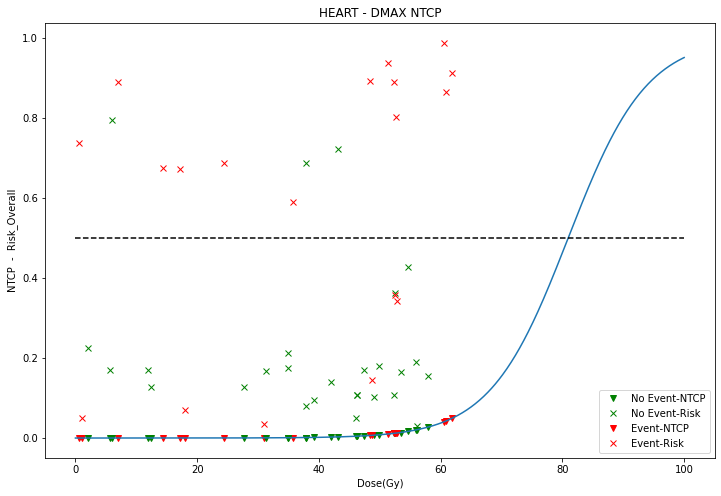

In [20]:
def NTCP(X, g, D50):
    z = g*X + D50
    return 1/(1+np.exp(z))

def get_NTCP(X, key):
    
    gd50 = {'V25': [-0.0235949, 5.796806], 
            'D4' : [-0.07193553, 6.95422],
            'D1' : [-0.1503416, 11.03224],
            'D0.5':[-0.1588655, 11.86569],
            'Dmax':[-0.1550583, 12.55338],
           }
    
    return NTCP(X, gd50[key][0], gd50[key][1])


def plot_organ_stat(organ, stat):
    ORGAN =organ
    STAT = stat

    # ORGAN = 'aorta'
    # STAT = 'D1'
    if STAT == 'Dmax':
        col = ORGAN + '_' + 'max_dose'
    elif STAT == 'V25':
        col = ORGAN + '_' + STAT.lower() + 'cc'
    else:
        col = ORGAN + '_' + STAT + 'cc'


    plt.figure(figsize=(12,8))

    label1a, label1b, label2a, label2b = ['Event-NTCP','Event-Risk','No Event-NTCP', 'No Event-Risk']
    red, green = False, False
    for i in range(len(df)):
        patient_event = df.iloc[i].Event
        patient_risk = val_results.iloc[i].predprob1

        organ_x = df.iloc[i][col]
        organ_x_ntcp = get_NTCP(organ_x, STAT)

        if patient_event == 1:
            plt.plot(organ_x, organ_x_ntcp, 'rv', label=label1a)
            plt.plot(organ_x, patient_risk,'rx',label=label1b)
            label1a = None
            label1b = None
        else:
            plt.plot(organ_x, organ_x_ntcp, 'gv', label=label2a)
            plt.plot(organ_x, patient_risk, 'gx', label=label2b)  
            label2a = None
            label2b = None


    plt.legend()

    doses = np.linspace(0,100,1000)
    y = get_NTCP(doses, STAT)
    plt.plot(doses,y)

    plt.plot(doses, [0.5 for _ in range(len(doses))], linestyle='--', color='black')
    plt.xlabel('Dose(Gy)')
    plt.ylabel('NTCP  -  Risk_Overall')
    plt.title(ORGAN.upper() + ' - ' + STAT.upper() + ' NTCP')


#     plt.show()


plot_organ_stat('heart', 'Dmax')


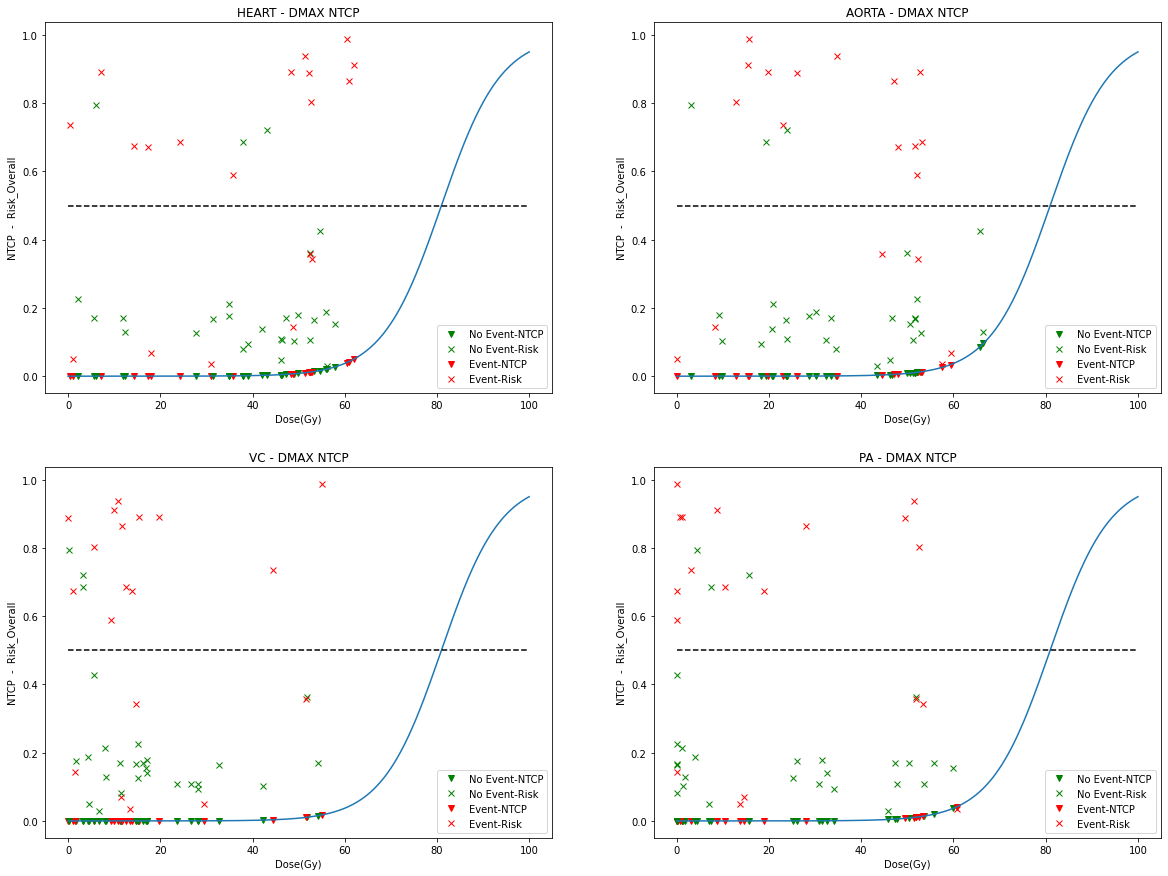

In [21]:
def NTCP(X, g, D50):
    z = g*X + D50
    return 1/(1+np.exp(z))

def get_NTCP(X, key):
    
    gd50 = {'V25': [-0.0235949, 5.796806], 
            'D4' : [-0.07193553, 6.95422],
            'D1' : [-0.1503416, 11.03224],
            'D0.5':[-0.1588655, 11.86569],
            'Dmax':[-0.1550583, 12.55338],
           }
    
    return NTCP(X, gd50[key][0], gd50[key][1])


def plot_organ_stat(organ, stat, ax):
    ORGAN =organ
    STAT = stat

    # ORGAN = 'aorta'
    # STAT = 'D1'
    if STAT == 'Dmax':
        col = ORGAN + '_' + 'max_dose'
    elif STAT == 'V25':
        col = ORGAN + '_' + STAT.lower() + 'cc'
    else:
        col = ORGAN + '_' + STAT + 'cc'


#     plt.figure(figsize=(12,8))

    label1a, label1b, label2a, label2b = ['Event-NTCP','Event-Risk','No Event-NTCP', 'No Event-Risk']
    for i in range(len(df)):
        patient_event = df.iloc[i].Event
        patient_risk = val_results.iloc[i].predprob1

        organ_x = df.iloc[i][col]
        organ_x_ntcp = get_NTCP(organ_x, STAT)

        if patient_event == 1:
            ax.plot(organ_x, organ_x_ntcp, 'rv', label=label1a)
            ax.plot(organ_x, patient_risk,'rx',label=label1b)
            label1a = None
            label1b = None
        else:
            ax.plot(organ_x, organ_x_ntcp, 'gv', label=label2a)
            ax.plot(organ_x, patient_risk, 'gx', label=label2b)  
            label2a = None
            label2b = None


    ax.legend()

    doses = np.linspace(0,100,1000)
    y = get_NTCP(doses, STAT)
    ax.plot(doses,y)

    ax.plot(doses, [0.5 for _ in range(len(doses))], linestyle='--', color='black')
    ax.set_xlabel('Dose(Gy)')
    ax.set_ylabel('NTCP  -  Risk_Overall')
    ax.set_title(ORGAN.upper() + ' - ' + STAT.upper() + ' NTCP')


#     plt.show()

f, axs = plt.subplots(2,2,figsize=(20,15))
organs = ['heart', 'aorta', 'vc', 'pa']
for i in range(2):
    for j in range(2):
#         print(2*i+j)
        plot_organ_stat(organs[2*i+j], 'Dmax', axs[i,j])




In [22]:
df.sort_values(by='aorta_D1cc', ascending=False).loc['MJ1'][['Timelag', 'Event', 'aorta_D1cc']]

Timelag           904
Event               1
aorta_D1cc    47.8921
Name: MJ1, dtype: object

In [23]:
df.Timelag.mean()/365

3.0016676593210248

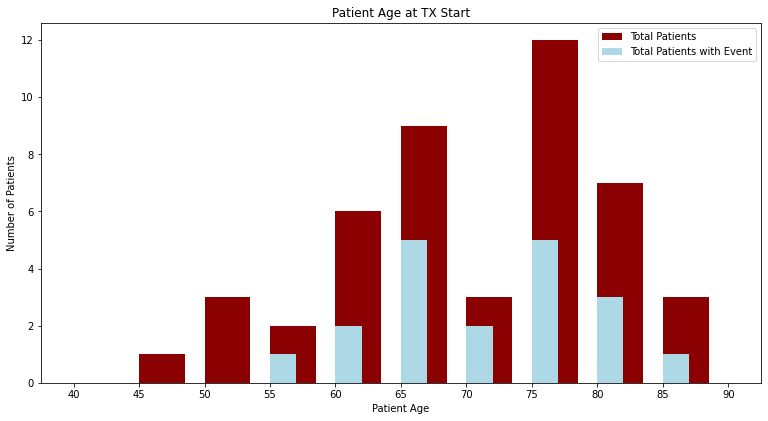

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

bins = [40,45,50,55,60,65,70,75,80,85,90]

ax.hist(df.Age_at_TX/365, bins=bins, width=3.5, color='darkred')
ax.hist(df[df.Event == 1].Age_at_TX/365, bins=bins, width=2, color='lightblue')
# ax.bar(cats,cat_total, width=0.6)
# ax.bar(cats,cat_correct, 0.2)
plt.title('Patient Age at TX Start')
plt.xticks(list(range(40,95,5)))
plt.ylabel('Number of Patients')
plt.xlabel('Patient Age')
plt.legend(['Total Patients','Total Patients with Event'])
# plt.savefig('resultsbyAge.png')
plt.show()


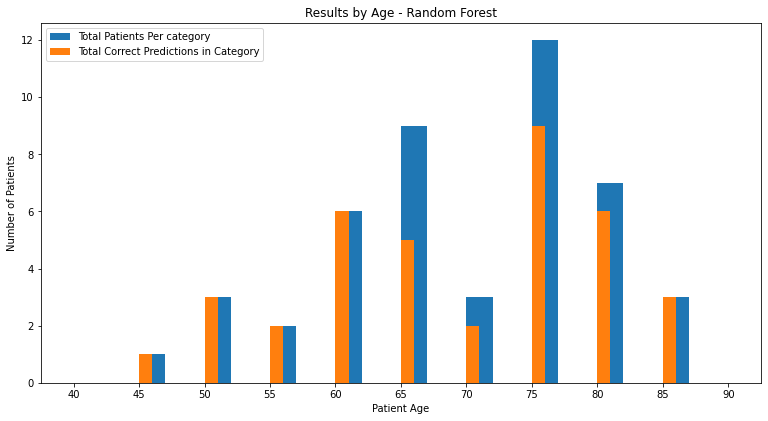

In [25]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

bins = [40,45,50,55,60,65,70,75,80,85,90]

ax.hist(val_results.Age, bins=bins, width=2)
ax.hist(val_results[val_results.Correct == 1].Age, bins=bins, width=1)
# ax.bar(cats,cat_total, width=0.6)
# ax.bar(cats,cat_correct, 0.2)
plt.title('Results by Age - Random Forest')
plt.xticks(list(range(40,95,5)))
plt.ylabel('Number of Patients')
plt.xlabel('Patient Age')
plt.legend(['Total Patients Per category','Total Correct Predictions in Category'])
# plt.savefig('resultsbyAge.png')
plt.show()


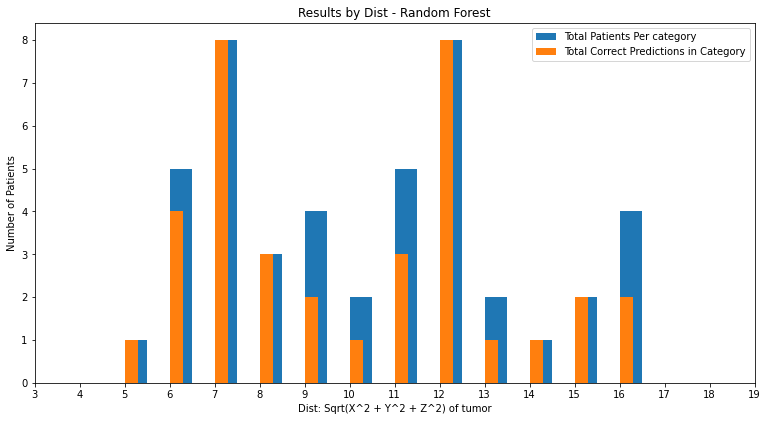

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
bins = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

ax.hist(val_results.Dist, bins=bins, width=0.5)
ax.hist(val_results[val_results.Correct == 1].Dist, bins=bins, width=0.3)
# ax.bar(cats,cat_total, width=0.6)
# ax.bar(cats,cat_correct, 0.2)
plt.title('Results by Dist - Random Forest')
plt.xticks(list(range(3,20,1)))
plt.ylabel('Number of Patients')
plt.xlabel('Dist: Sqrt(X^2 + Y^2 + Z^2) of tumor')
plt.legend(['Total Patients Per category','Total Correct Predictions in Category'])
# plt.savefig('resultsbyAge.png')
plt.show() 


In [34]:
val_results[val_results.Correct==0]

,Event,pred,predprob0,predprob1,Correct,Timelag,Smoke,Age,Dist
KS,0,1.0,0.313415,0.686585,0,550,Current,68.158904,16.982904
LL,1,0.0,0.950650,0.049350,0,1086,Former(30+),68.556164,11.623984
HI,1,0.0,0.965254,0.034746,0,1042,Never,69.079452,6.565289
RD,1,0.0,0.656882,0.343118,0,680,Former(30+),69.520548,9.935539
MJ1,1,0.0,0.931206,0.068794,0,904,Former(30+),76.347945,9.050757
AJ,1,0.0,0.642938,0.357062,0,636,Former,72.545205,13.339224
DA,0,1.0,0.278702,0.721298,0,636,Former,84.142466,11.618155
IB,1,0.0,0.856131,0.143869,0,1376,Former(30+),78.265753,16.539380
PG,0,1.0,0.204734,0.795266,0,705,Former(30+),76.463014,10.641388


In [39]:
# plt.figure(figsize=(10,7))
# df.plot(kind='scatter', x='heart_v25cc', y='Z',figsize=(10,7), colorbar=True)
# df.plot(kind='scatter', x='heart_v25cc', y='Z',figsize=(10,7) ,c=1-df['Event'])

df[df.Event == 0][['Event','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']]

x = df.loc[['KS', 'DA','PG','LL', 'HI', 'RD', 'MJ1', 'AJ', 'IB'],['Event','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']]
x['prediction'] = val_results.loc[['KS', 'DA','PG','LL', 'HI', 'RD', 'MJ1', 'AJ', 'IB'],['predprob1']]
x[['Event','prediction','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']]
# import seaborn
# seaborn.set(style='ticks')
# plt.figure(figsize=(10,7))

# fg = seaborn.FacetGrid(data=df, hue='Event', size=8)
# fg.map(plt.scatter, 'heart_v25cc', 'Y',).add_legend()


,Event,prediction,heart_v25cc,heart_max_dose,aorta_v25cc,aorta_max_dose,pa_v25cc,pa_max_dose,vc_v25cc,vc_max_dose
KS,0,0.686585,2.328125,37.910853,0.000000,19.277748,0.000000,7.424156,0.000000,3.185763
DA,0,0.721298,6.125000,43.139677,0.000000,23.981422,0.000000,15.742631,0.000000,3.307078
PG,0,0.795266,0.000000,6.056546,0.000000,3.131939,0.000000,4.382165,0.000000,0.270842
LL,1,0.049350,0.000000,1.090614,0.000000,0.094535,0.000000,13.725299,0.890625,29.529727
HI,1,0.034746,1.109375,31.011604,39.609375,57.496405,13.890625,60.819327,0.000000,13.377234
RD,1,0.343118,44.593750,52.851391,42.484375,52.413933,4.328125,53.415919,0.000000,14.701987
MJ1,1,0.068794,0.000000,18.014192,8.281250,59.407711,0.000000,14.569057,0.000000,11.454040
AJ,1,0.357062,47.265625,52.500380,10.718750,44.559248,2.656250,51.934535,9.453125,51.651730
IB,1,0.143869,4.687500,48.680009,0.000000,8.373321,0.000000,0.000000,0.000000,1.412482


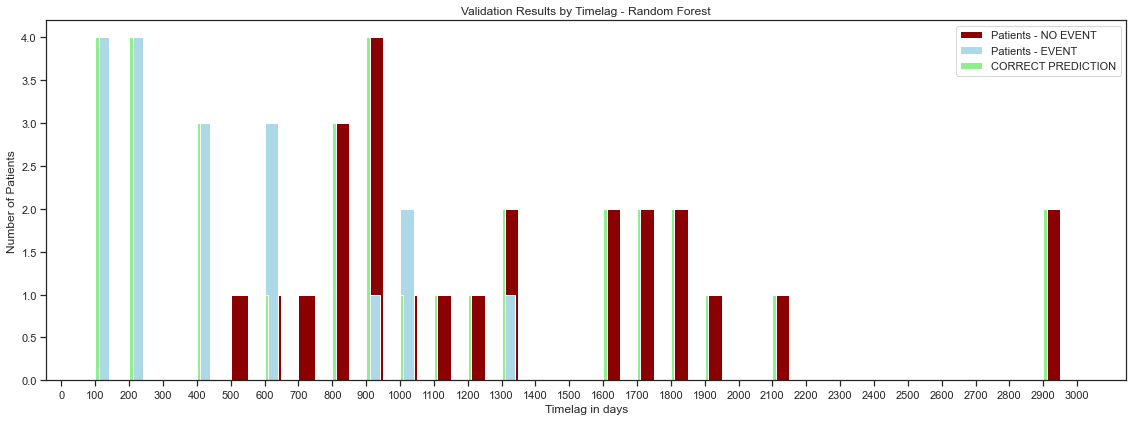

In [40]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

bins = [100,200,300,400,500,600,700,800,900,1000, 
        1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,
        2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]

noevent = val_results[val_results.Event == 0]
event = val_results[val_results.Event == 1]

ax.hist(noevent.Timelag, bins=bins, width=50, color='darkred')
# ax.hist(noevent[noevent.Correct == 1].Timelag, bins=bins, width=20, color='#0EB038')
ax.hist(event.Timelag, bins=bins, width=40, color='lightblue')
# ax.hist(event[event.Correct == 1].Timelag, bins=bins, width=20, color='#0EB038')

# ax.hist(val_results[val_results.Correct == 0].Timelag, bins=bins, width=10, color='red')
ax.hist(val_results[val_results.Correct == 1].Timelag, bins=bins, width=10, color='lightgreen')

plt.title('Validation Results by Timelag - Random Forest')
plt.xticks(list(range(0,3100,100)))
plt.ylabel('Number of Patients')
plt.xlabel('Timelag in days')
plt.legend(['Patients - NO EVENT','Patients - EVENT', 'CORRECT PREDICTION', 'c'])
# plt.savefig('resultsbyAge.png')
plt.show() 


In [41]:
a = df[df.Event == 1]
a[a.Timelag == a.Timelag.max()]

,Sex,Race,Smoke,Tumor_Loc,Prior_Courses,X,Y,Z,Age_at_TX,Timelag,...,pa_max_dose,pa_v25cc,pa_D0.5cc,pa_D1cc,pa_D4cc,vc_max_dose,vc_v25cc,vc_D0.5cc,vc_D1cc,vc_D4cc
IB,0,White,Former(30+),LLL,1,8.591,11.651,8.0,28567,1376,...,0.0,0.0,0.0,0.0,0.0,1.412482,0.0,0.340476,0.298315,0.240016


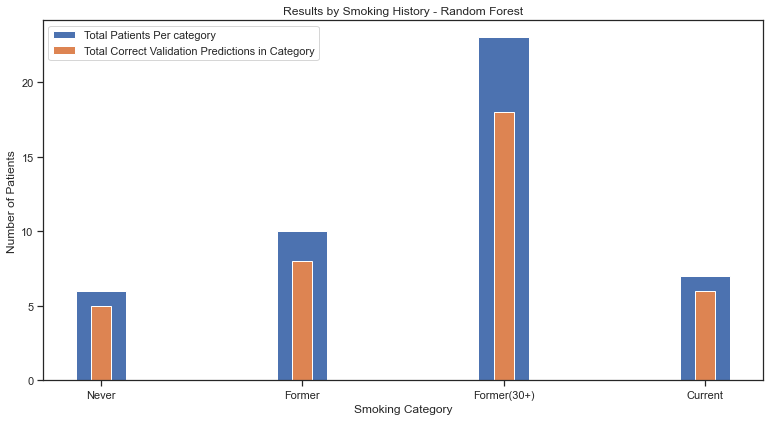

In [42]:
cat_percents_all = []
cat_percents_val = []
categories = ['Never', 'Former', 'Former(30+)','Current']
cat_total = []
cat_correct = []

cats = ['Never', 'Former', 'Former(30+)', 'Current']

for cat in categories:
    y = val_results[val_results['Smoke']==cat]
    cat_total.append(len(y))
    cat_correct.append(sum(y.Correct))
#     cat_correct_val.append(sum(y.correct))
    
#     cat_percents_all.append(sum(x.Correct)/len(x))
#     cat_percents_val.append(sum(y.Correct)/len(y))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(cats,cat_total, width=0.25)
ax.bar(cats,cat_correct, width=0.1)
plt.title('Results by Smoking History - Random Forest')
plt.ylabel('Number of Patients')
plt.xlabel('Smoking Category')
plt.legend(['Total Patients Per category','Total Correct Validation Predictions in Category'])
# plt.savefig('resultsbySmoke.png')
plt.show()


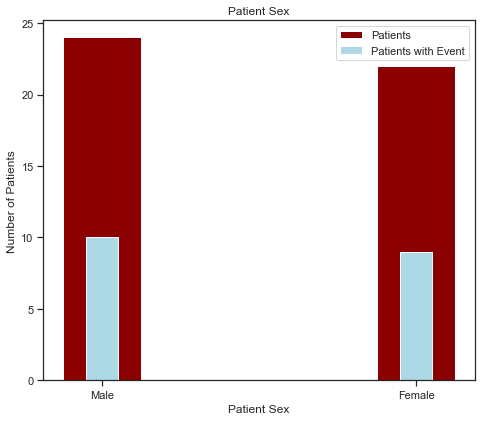

In [43]:
# 0M 1F
cats = ['Male', 'Female']
cat_total = []
cat_correct = []

for i in range(2):
    y = df[df.Sex==i]
    cat_total.append(len(y))
    cat_correct.append(sum(y.Event ==1))

fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(cats,cat_total, width=0.25, color='darkred')
ax.bar(cats,cat_correct, 0.1, color='lightblue')
plt.title('Patient Sex')
plt.ylabel('Number of Patients')
plt.xlabel('Patient Sex')
plt.legend(['Patients','Patients with Event'])
# plt.savefig('resultsbySex.png')
plt.show()


In [101]:
dfcop = df.copy()
labcop = train_labels.copy()

In [102]:
# df.drop(['HM1', 'TC', 'DJ1', 'SR1'], inplace=True)
# train_labels.drop(['HM1', 'TC', 'DJ1', 'SR1'], inplace=True)

In [103]:
df

,Sex,Race,Smoke,Tumor_Loc,Prior_Courses,X,Y,Z,Age_at_TX,Timelag,...,pa_max_dose,pa_v25cc,pa_D0.5cc,pa_D1cc,pa_D4cc,vc_max_dose,vc_v25cc,vc_D0.5cc,vc_D1cc,vc_D4cc
CW,1,White,Former(30+),LUL,1,7.123,1.921,4.0,27878,1721,...,59.937246,7.015625,56.169084,52.084464,34.357566,17.012399,0.000000,15.507949,14.838689,8.396051
KS,1,White,Current,L LINGULA,1,10.655,9.200,9.5,24878,550,...,7.424156,0.000000,5.437350,4.840003,1.273314,3.185763,0.000000,2.866407,2.692640,1.623593
MB,1,White,Former,LUL,1,5.684,3.735,4.0,24824,1719,...,45.830279,0.828125,28.620957,23.761683,13.592739,6.813677,0.000000,6.409245,6.232062,5.417848
LL,1,White,Former(30+),RLL,1,-0.994,5.842,10.0,25023,1086,...,13.725299,0.000000,8.966031,6.849898,3.434567,29.529727,0.890625,26.040380,24.561707,20.574073
BE,1,White,Former(30+),LLL,1,4.044,2.661,4.0,32103,2974,...,1.690538,0.000000,1.045227,0.911218,0.632209,8.234732,0.000000,7.709190,7.302297,2.832789
PJ2,1,White,Former(30+),LUL,1,4.572,5.149,4.0,27611,993,...,53.604116,24.343750,52.891329,52.327772,49.982908,23.646790,0.000000,21.509893,20.671877,16.810428
GV,1,White,Former,RLL,1,-3.765,6.468,11.0,28582,253,...,0.000000,0.000000,0.000000,0.000000,0.000000,55.076543,2.078125,41.668573,35.687942,16.065796
IP,1,White,Never,RLL,1,-1.160,4.818,9.0,28717,2914,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.780464,0.828125,26.591941,24.614458,19.555801
DJ,1,White,Never,LLL,1,6.508,2.597,10.0,30866,263,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.300355,0.000000,6.598783,6.047826,3.400386
BC,0,African American,Current,RUL,1,-3.340,4.470,4.0,21272,434,...,3.023778,0.000000,1.806428,1.561708,1.028205,44.463597,8.750000,42.536447,41.082362,34.239839


**NO TIMELAG**

In [104]:
train_data_2 = df.drop(['Timelag', 'Event'], axis=1)
categorical_features = ['Race', 'Smoke', 'Tumor_Loc']
numerical_features_2 = list(train_data_2.drop(categorical_features, axis=1).columns)

In [105]:
num_pipeline_2 = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
onehot_features = onehot_features = ['Race', 'Tumor_Loc'] # race -> 3 dim, Loc -> 5 dim
smoke_cats = [np.array(['Never', 'Former', 'Former(30+)', 'Current'])]
full_pipeline_2 = ColumnTransformer([
        ("num", num_pipeline_2, numerical_features_2),
        ("cat_ord", OrdinalEncoder(categories=smoke_cats), ['Smoke']),
        ("cat_onehot", OneHotEncoder(), onehot_features), 
    ])
train_data_2_prep = full_pipeline_2.fit_transform(train_data_2)
train_data_2_prep.shape

(42, 36)

In [106]:
grid_notimelag = GridSearchCV(RandomForestClassifier(random_state=2), param_grid=param_grid, cv=5, scoring='accuracy')
grid_notimelag.fit(train_data_2_prep, train_labels)
print('GridSearch Best CV score:',grid_notimelag.best_score_)
grid_notimelag.best_params_

GridSearch Best CV score: 0.5694444444444444


{'max_depth': 4, 'max_features': None, 'n_estimators': 50}

In [107]:
clf2 = RandomForestClassifier(**grid_notimelag.best_params_, random_state=2)
clf2.fit(train_data_2_prep[:30], train_labels[:30])

predictions_2 = clf2.predict(train_data_2_prep)
predictions_prob_2 = clf2.predict_proba(train_data_2_prep)
print('\n**********************RESULTS**********************')
print()
print('OVERALL ACCURACY:',accuracy_score(predictions_2, train_labels))
print()
# print('VALIDATION ACCURACY:', accuracy_score(predictions_2[30:], train_labels[30:]))
print('\n\n')


**********************RESULTS**********************

OVERALL ACCURACY: 0.8809523809523809






In [108]:
feature_list_2 = numerical_features_2.copy()
feature_list_2.extend(['Smoke'])#list(smoke_cats[0]))
feature_list_2.extend(['Race1','Race2','Race3','Tumor_Loc1','Tumor_Loc2','Tumor_Loc3','Tumor_Loc4','Tumor_Loc5','Tumor_Loc6'])
len(feature_list_2)

36

In [109]:
feat_importances_notimelag = pd.DataFrame(columns=feature_list_2, data=[grid_notimelag.best_estimator_.feature_importances_])
nonzero_feats = []
for feat in feature_list_2:
    if feat_importances_notimelag.iloc[0][feat] != 0:
        nonzero_feats.append(feat)
feat_importances_notimelag = feat_importances_notimelag[nonzero_feats].T
feat_importances_notimelag.columns = ['importance']
feat_importances_notimelag['EventCorr'] = [0 for _ in range(len(feat_importances_notimelag))]
corr = df.corr()
# corr.shape
eventcorr = pd.DataFrame(columns =['EventCorr'])
eventcorr.EventCorr = corr['Event']
eventcorr
feat_importances_notimelag.update(eventcorr)


feat_importances_notimelag.sort_values(by='importance', ascending=False)

,importance,EventCorr
aorta_D0.5cc,0.175049,-0.007248
Y,0.158711,0.240256
heart_D0.5cc,0.076609,0.011445
Smoke,0.055546,0.000000
heart_D1cc,0.052638,0.028418
heart_D4cc,0.049256,0.073387
aorta_D4cc,0.039624,0.035202
vc_D4cc,0.038644,-0.079189
Age_at_TX,0.034642,0.155583
heart_max_dose,0.030910,-0.013110


In [110]:
val_results_notimelag = get_kfold_predictions(train_data_2_prep, train_labels, grid_notimelag.best_params_, verbose=True)    
val_results_notimelag['Timelag'] = df.Timelag
val_results_notimelag['Smoke'] = df.Smoke
val_results_notimelag['Age'] = df['Age_at_TX']/365
val_results_notimelag['Dist'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**.5
val_results_notimelag

Fold: 0 --- Val set: ['CW', 'KS', 'MB', 'LL', 'BE', 'PJ2', 'GV', 'IP', 'DJ']
Val Accuracy: 0.8888888888888888
Overall Accuracy: 0.9761904761904762



Fold: 1 --- Val set: ['BC', 'SB', 'PM', 'SW', 'MM1', 'DM', 'MK', 'DE', 'HI']
Val Accuracy: 0.4444444444444444
Overall Accuracy: 0.8809523809523809



Fold: 2 --- Val set: ['LK', 'RD', 'MJ1', 'VE', 'WL', 'GB', 'FJ', 'BL']
Val Accuracy: 0.75
Overall Accuracy: 0.9523809523809523



Fold: 3 --- Val set: ['BB2', 'PP', 'BY', 'CT', 'AJ', 'HD', 'LJ', 'HL']
Val Accuracy: 0.5
Overall Accuracy: 0.9047619047619048



Fold: 4 --- Val set: ['PJ', 'DA', 'WT', 'FJ1', 'IB', 'WJ', 'TA', 'PG']
Val Accuracy: 0.5
Overall Accuracy: 0.9047619047619048



Validation Accuracy: 0.6190476190476191


,Event,pred,predprob0,predprob1,Correct,Timelag,Smoke,Age,Dist
CW,0,0.0,0.603602,0.396398,1,1721,Former(30+),76.378082,8.392102
KS,0,0.0,0.737612,0.262388,1,550,Current,68.158904,16.982904
MB,0,0.0,0.624695,0.375305,1,1719,Former,68.010959,7.890379
LL,1,1.0,0.436583,0.563417,1,1086,Former(30+),68.556164,11.623984
BE,0,0.0,0.712269,0.287731,1,2974,Former(30+),87.953425,6.279718
PJ2,0,0.0,0.519928,0.480072,1,993,Former(30+),75.646575,7.963378
GV,1,0.0,0.516667,0.483333,0,253,Former,78.306849,13.304520
IP,0,0.0,0.617081,0.382919,1,2914,Never,78.676712,10.274178
DJ,1,1.0,0.419167,0.580833,1,263,Never,84.564384,12.210589
BC,1,0.0,0.778947,0.221053,0,434,Current,58.279452,6.865603


In [97]:
mistakes = list(val_results_notimelag[val_results_notimelag.Correct==0].index)

In [98]:
# plt.figure(figsize=(10,7))
# df.plot(kind='scatter', x='heart_v25cc', y='Z',figsize=(10,7), colorbar=True)
# df.plot(kind='scatter', x='heart_v25cc', y='Z',figsize=(10,7) ,c=1-df['Event'])

df[df.Event == 0][['Event','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']]

y = df.loc[mistakes,['Event','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']]
y['prediction'] = val_results_notimelag.loc[mistakes,['predprob1']]
y[['Event','prediction','heart_v25cc','heart_max_dose', 'aorta_v25cc','aorta_max_dose','pa_v25cc','pa_max_dose','vc_v25cc','vc_max_dose']].sort_values(by='Event')

# import seaborn
# seaborn.set(style='ticks')
# plt.figure(figsize=(10,7))

# fg = seaborn.FacetGrid(data=df, hue='Event', size=8)
# fg.map(plt.scatter, 'heart_v25cc', 'Y',).add_legend()


,Event,prediction,heart_v25cc,heart_max_dose,aorta_v25cc,aorta_max_dose,pa_v25cc,pa_max_dose,vc_v25cc,vc_max_dose
SB,0,0.810000,36.046875,52.418956,8.609375,49.953960,1.203125,51.780766,5.546875,51.812725
CT,0,0.880000,0.000000,5.617657,33.015625,51.599613,4.828125,50.410052,0.000000,16.269149
LJ,0,0.780000,4.203125,54.609698,12.015625,65.684605,0.000000,0.000000,0.000000,5.639172
HL,0,0.710000,12.546875,49.881474,0.000000,9.055674,0.421875,31.535676,0.000000,17.177190
WJ,0,0.580952,0.000000,2.082134,8.609375,52.070930,0.000000,0.000000,0.000000,15.146054
PG,0,0.728571,0.000000,6.056546,0.000000,3.131939,0.000000,4.382165,0.000000,0.270842
GV,1,0.483333,19.859375,60.471948,0.000000,15.761207,0.000000,0.000000,2.078125,55.076543
BC,1,0.221053,0.000000,0.513207,0.000000,23.076514,0.000000,3.023778,8.750000,44.463597
MM1,1,0.142164,0.000000,24.366144,12.375000,53.123147,0.000000,10.443853,0.000000,12.488627
DE,1,0.420000,0.000000,14.347536,35.468750,51.694292,0.000000,19.008777,0.000000,1.105028


In [99]:
sum(val_results_notimelag[val_results_notimelag['Correct']==0].Event)

10

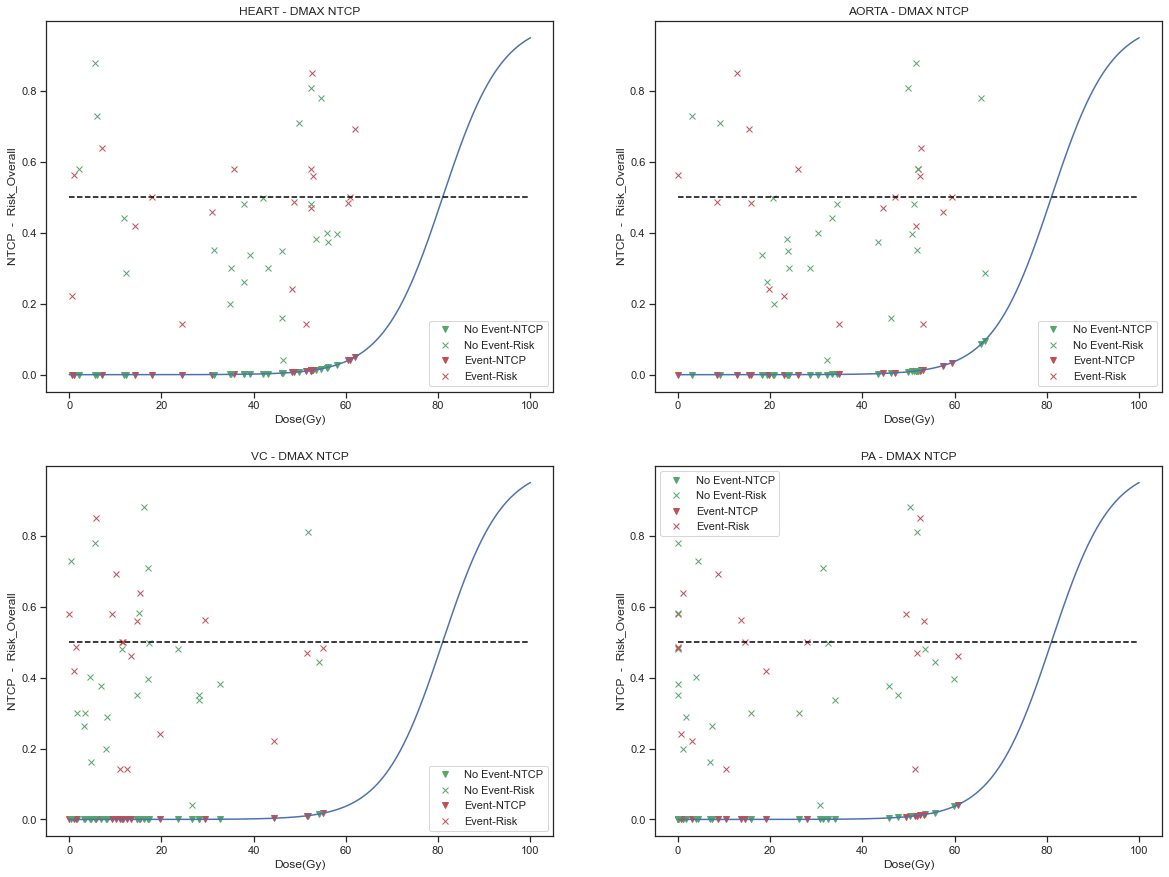

In [100]:
def plot_organ_stat_notimelag(organ, stat, ax):
    ORGAN =organ
    STAT = stat

    # ORGAN = 'aorta'
    # STAT = 'D1'
    if STAT == 'Dmax':
        col = ORGAN + '_' + 'max_dose'
    elif STAT == 'V25':
        col = ORGAN + '_' + STAT.lower() + 'cc'
    else:
        col = ORGAN + '_' + STAT + 'cc'


#     plt.figure(figsize=(12,8))

    label1a, label1b, label2a, label2b = ['Event-NTCP','Event-Risk','No Event-NTCP', 'No Event-Risk']
    for i in range(len(df)):
        patient_event = df.iloc[i].Event
        patient_risk = val_results_notimelag.iloc[i].predprob1

        organ_x = df.iloc[i][col]
        organ_x_ntcp = get_NTCP(organ_x, STAT)

        if patient_event == 1:
            ax.plot(organ_x, organ_x_ntcp, 'rv', label=label1a)
            ax.plot(organ_x, patient_risk,'rx',label=label1b)
            label1a = None
            label1b = None
        else:
            ax.plot(organ_x, organ_x_ntcp, 'gv', label=label2a)
            ax.plot(organ_x, patient_risk, 'gx', label=label2b)  
            label2a = None
            label2b = None


    ax.legend()

    doses = np.linspace(0,100,1000)
    y = get_NTCP(doses, STAT)
    ax.plot(doses,y)

    ax.plot(doses, [0.5 for _ in range(len(doses))], linestyle='--', color='black')
    ax.set_xlabel('Dose(Gy)')
    ax.set_ylabel('NTCP  -  Risk_Overall')
    ax.set_title(ORGAN.upper() + ' - ' + STAT.upper() + ' NTCP')


#     plt.show()

f, axs = plt.subplots(2,2,figsize=(20,15))
organs = ['heart', 'aorta', 'vc', 'pa']
for i in range(2):
    for j in range(2):
#         print(2*i+j)
        plot_organ_stat_notimelag(organs[2*i+j], 'Dmax', axs[i,j])




**Timelag > 300**

In [51]:
train_data_s = df.copy()
train_data_s.shape
train_data_s = train_data_s[train_data_s.Timelag > 300]
train_labels_s = train_data_s['Event']
train_data_s.drop(['Event'], axis=1, inplace=True)

train_data_s_prep = full_pipeline.fit_transform(train_data_s)
train_data_s_prep.shape

(37, 36)

In [52]:
val_results_timelag300 = get_kfold_predictions(train_data_s_prep, train_labels_s, grid.best_params_, verbose=True)    
val_results_timelag300

Fold: 0 --- Val set: ['CW', 'HM1', 'KS', 'MB', 'LL', 'TC', 'BE', 'PJ2']
Val Accuracy: 0.875
Overall Accuracy: 0.9459459459459459



Fold: 1 --- Val set: ['DJ1', 'IP', 'SR1', 'BC', 'SB', 'PM', 'SW', 'DM']
Val Accuracy: 0.75
Overall Accuracy: 0.8918918918918919



Fold: 2 --- Val set: ['HI', 'LK', 'RD', 'MJ1', 'VE', 'WL', 'FJ']
Val Accuracy: 0.42857142857142855
Overall Accuracy: 0.8648648648648649



Fold: 3 --- Val set: ['BL', 'BB2', 'PP', 'BY', 'CT', 'AJ', 'LJ']
Val Accuracy: 0.5714285714285714
Overall Accuracy: 0.8648648648648649



Fold: 4 --- Val set: ['HL', 'DA', 'WT', 'IB', 'WJ', 'TA', 'PG']
Val Accuracy: 0.5714285714285714
Overall Accuracy: 0.918918918918919



Validation Accuracy: 0.6486486486486487


,Event,pred,predprob0,predprob1,Correct
CW,0,0.0,0.850095,0.149905,1
HM1,0,0.0,0.747163,0.252837,1
KS,0,0.0,0.502634,0.497366,1
MB,0,0.0,0.959539,0.040461,1
LL,1,0.0,0.883336,0.116664,0
TC,0,0.0,0.741508,0.258492,1
BE,0,0.0,0.895408,0.104592,1
PJ2,0,0.0,0.769603,0.230397,1
DJ1,1,0.0,0.668648,0.331352,0
IP,0,0.0,0.738230,0.261770,1


**Subtract min timelag**

In [40]:
x = df[df.Event ==0]
print('Min Timelag for patient with no event:',int(x[x['Timelag'] == min(x.Timelag)].Timelag))

Min Timelag for patient with no event: 550


In [41]:
# subtract min timelag
train_data = df.copy()
lst = []
for i in range(len(train_data)):
    t = int(train_data.iloc[i].Timelag)
    if train_data.iloc[i].Event == 0:
        t -= 549
    lst.append(t)
    
train_data.Timelag = lst
train_data_prep_mintimelag = full_pipeline.fit_transform(train_data)
train_data_prep_mintimelag.shape

(46, 37)

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[50,100,200],
    'max_depth':[2,4,8,None],
    'max_features':[2,4,8,None],
#     'verbose':[0],
}

grid = GridSearchCV(RandomForestClassifier(random_state=2), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(train_data_prep_mintimelag, train_labels)
print('GridSearch Best CV score:',grid.best_score_)

GridSearch Best CV score: 0.5666666666666667


In [43]:
clf = RandomForestClassifier(**grid.best_params_)
clf.fit(train_data_prep_mintimelag[:35], train_labels[:35])
pred_mintimelag = clf.predict(train_data_prep_mintimelag)
accuracy_score(pred_mintimelag, train_labels)

0.8913043478260869

In [44]:
feat_importances = pd.DataFrame(columns=feature_list, data=[grid.best_estimator_.feature_importances_])
nonzero_feats = []
for feat in feature_list:
    if feat_importances.iloc[0][feat] != 0:
        nonzero_feats.append(feat)
feat_importances = feat_importances[nonzero_feats].T
feat_importances.columns = ['importance']
feat_importances['EventCorr'] = [0 for _ in range(len(feat_importances))]
corr = train_data.corr()
# corr.shape
eventcorr = pd.DataFrame(columns =['EventCorr'])
eventcorr.EventCorr = corr['Event']
eventcorr
feat_importances.update(eventcorr)


feat_importances.sort_values(by='importance', ascending=False)


,importance,EventCorr
Timelag,0.078463,-0.359720
heart_D0.5cc,0.076453,-0.040673
Y,0.076259,0.237121
heart_D1cc,0.061928,-0.026303
vc_D4cc,0.055739,-0.087971
heart_max_dose,0.054744,-0.051856
aorta_D0.5cc,0.053765,-0.000307
aorta_D4cc,0.049480,0.015509
vc_max_dose,0.041950,0.003116
heart_D4cc,0.040109,0.009923


In [45]:
val_results_f = get_kfold_predictions(train_data_prep_mintimelag, train_labels, grid.best_params_, verbose=True)    
val_results_f['Timelag'] = train_data.Timelag


Fold: 0 --- Val set: ['CW', 'HM1', 'KS', 'MB', 'LL', 'TC', 'BE', 'PJ2', 'GV', 'DJ1']
Val Accuracy: 0.7
Overall Accuracy: 0.9347826086956522



Fold: 1 --- Val set: ['IP', 'SR1', 'DJ', 'BC', 'SB', 'PM', 'SW', 'MM1', 'DM']
Val Accuracy: 0.5555555555555556
Overall Accuracy: 0.9130434782608695



Fold: 2 --- Val set: ['MK', 'DE', 'HI', 'LK', 'RD', 'MJ1', 'VE', 'WL', 'GB']
Val Accuracy: 0.3333333333333333
Overall Accuracy: 0.8695652173913043



Fold: 3 --- Val set: ['FJ', 'BL', 'BB2', 'PP', 'BY', 'CT', 'AJ', 'HD', 'LJ']
Val Accuracy: 0.3333333333333333
Overall Accuracy: 0.8478260869565217



Fold: 4 --- Val set: ['HL', 'PJ', 'DA', 'WT', 'FJ1', 'IB', 'WJ', 'TA', 'PG']
Val Accuracy: 0.5555555555555556
Overall Accuracy: 0.9130434782608695



Validation Accuracy: 0.5


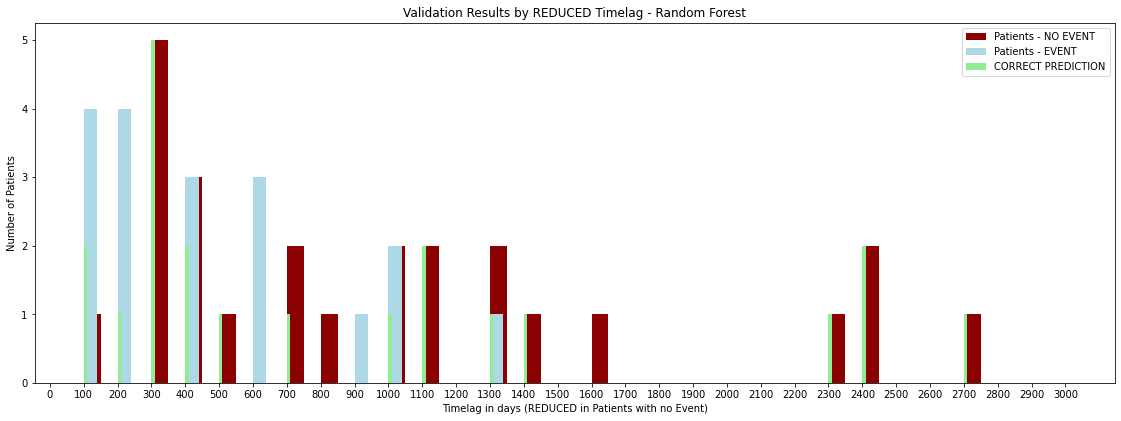

In [50]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

bins = [100,200,300,400,500,600,700,800,900,1000, 
        1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,
        2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]

noevent = val_results_f[val_results_f.Event == 0]
event = val_results_f[val_results_f.Event == 1]

ax.hist(noevent.Timelag, bins=bins, width=50, color='darkred')
# ax.hist(noevent[noevent.Correct == 1].Timelag, bins=bins, width=20, color='#0EB038')
ax.hist(event.Timelag, bins=bins, width=40, color='lightblue')
# ax.hist(event[event.Correct == 1].Timelag, bins=bins, width=20, color='#0EB038')

# ax.hist(val_results_f[val_results_f.Correct == 0].Timelag, bins=bins, width=10, color='red')
ax.hist(val_results_f[val_results_f.Correct == 1].Timelag, bins=bins, width=10, color='lightgreen')


plt.title('Validation Results by REDUCED Timelag - Random Forest')
plt.xticks(list(range(0,3100,100)))
plt.ylabel('Number of Patients')
plt.xlabel('Timelag in days (REDUCED in Patients with no Event)')
plt.legend(['Patients - NO EVENT','Patients - EVENT', 'CORRECT PREDICTION'])
# plt.savefig('resultsbyAge.png')
plt.show() 


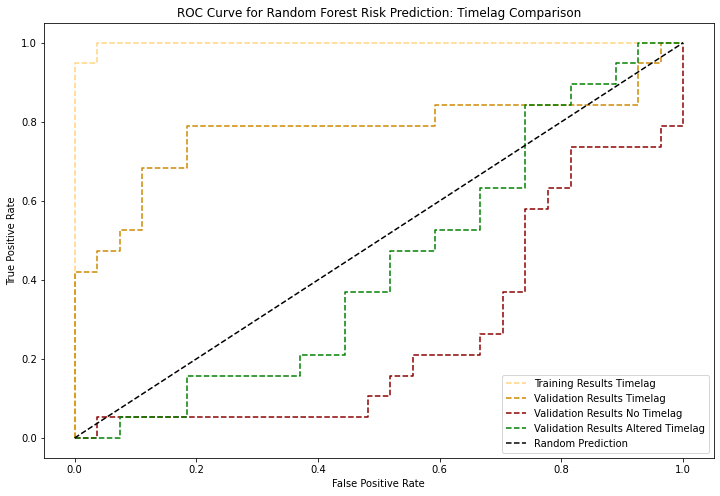

AUC scores

Train data w/ Timelag: 0.9980506822612085
Validation data w/ Timelag: 0.7777777777777778

Validation data no Timelag: 0.26315789473684215

Validation data Timelag altered: 0.4366471734892788


In [47]:
# train including timelag
# t_fpr, t_tpr, _ = roc_curve(train_labels, predictions)
t_fpr_2, t_tpr_2, _ = roc_curve(train_labels, predictions_prob[:,1])

# validate including timelag
# tv_fpr, tv_tpr, _ = roc_curve(train_labels, val_results.pred)
tv_fpr_2, tv_tpr_2, _ = roc_curve(train_labels, val_results.predprob1)

# train no timelag
# x_fpr, x_tpr, _ = roc_curve(train_labels, predictions_2)
# x_fpr_2, x_tpr_2, _ = roc_curve(train_labels, predictions_prob_2[:,1])

# validate no timelag
# xv_fpr, xv_tpr, _ = roc_curve(train_labels, val_results_notimelag.pred)
xv_fpr_2, xv_tpr_2, _ = roc_curve(train_labels, val_results_notimelag.predprob1)

# validate altered timelag
# lv_fpr, lv_tpr, _ = roc_curve(train_labels_s, val_results_timelag300.pred)
# lv_fpr_2, lv_tpr_2, _ = roc_curve(train_labels_s, val_results_timelag300.predprob1)
lv_fpr_2, lv_tpr_2, _ = roc_curve(train_labels, val_results_f.predprob1)





random_pred = [0 for _ in range(len(train_labels))]
r_fpr, r_tpr, _ = roc_curve(train_labels, random_pred)



plt.figure(figsize=(12,8))
# plt.plot(t_fpr, t_tpr, label='With Timelag - Hard Prediction', color='orange')
plt.plot(t_fpr_2, t_tpr_2, linestyle='--', label='Training Results Timelag', color='#ffd480')
plt.plot(tv_fpr_2, tv_tpr_2, linestyle='--', label='Validation Results Timelag', color='#cc8800')


# plt.plot(x_fpr, x_tpr, label='No Timelag - Hard Prediction', color='blue')
# plt.plot(x_fpr_2, x_tpr_2, linestyle='--', label='No Timelag(Train) - Probability Prediction', color='lightblue')
plt.plot(xv_fpr_2, xv_tpr_2, linestyle='--', label='Validation Results No Timelag', color='darkred')

# plt.plot(x_fpr_2, x_tpr_2, linestyle='--', label='No Timelag(Train) - Probability Prediction', color='lightblue')
plt.plot(lv_fpr_2, lv_tpr_2, linestyle='--', label='Validation Results Altered Timelag', color='green')



plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Prediction', color='black')


plt.title('ROC Curve for Random Forest Risk Prediction: Timelag Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


print('AUC scores\n')
print('Train data w/ Timelag:',auc(t_fpr_2, t_tpr_2))
print('Validation data w/ Timelag:',auc(tv_fpr_2, tv_tpr_2))
print()
# print('Train data no Timelag:',auc(x_fpr_2, x_tpr_2))
print('Validation data no Timelag:',auc(xv_fpr_2, xv_tpr_2))
print()
print('Validation data Timelag altered:',auc(lv_fpr_2, lv_tpr_2))

# print('No Timelag:',auc(x_fpr, x_tpr))



**TODO - Rest of semester**

- fix reading in voxel volume in pipeline/get_voxel_doses - done
- fix pipeline to compute D statistics from CDVH - done
- fix pipeline to compute NTCP - done
- fix pipeline to take patient from command line - done
- test save CDVH - done
- rerun all code
- thoroughly comment code
- fix run_pipeline process
- fix Spring2020 to handle too many for each organ
- write readme file explaining
    - what each file does
    - how to run everything
    - venv and file organzation
- document results for both with timelag and without timelag
- plot ROC curve - done
- correlations and standard dev from different CV folds
- plot ntcp prediction vs model prediction
- get results from predictions in cross val
- try regularization on model(s)
- write first reflection of only ML piece
- Write/edit paper
- regression on time lag


In [12]:
# returns DF
def get_kfold_predictions_SVC(train_data_prep, train_labels, model_params, k=5, verbose=False):
    kf = KFold(n_splits=5, shuffle=False)
    val_results = pd.DataFrame(train_labels.copy())
    lst = [0 for _ in range(len(val_results))]
    val_results['pred'] = lst
    val_results['predprob0'] = lst
    val_results['predprob1'] = lst

    val_folds = []

    for i, inds in enumerate(kf.split(train_data_prep, train_labels)):
        clf = SVC(**model_params, random_state=2, probability=True)
        train_idx, val_idx = inds
    #     print(train_idx)
    #     print(val_idx)
        clf.fit(train_data_prep[train_idx], train_labels[train_idx])
        
        predicted_val = clf.predict(train_data_prep[val_idx])
        predicted_prob_val = clf.predict_proba(train_data_prep[val_idx])

        pred_overall = clf.predict(train_data_prep)
        pred_prob_overall = clf.predict_proba(train_data_prep)

        val_folds.append(list(train_labels.index[val_idx]))
        
        new = pd.DataFrame(columns= ['pred', 'predprob0', 'predprob1'],index=val_folds[i])
        new.pred = predicted_val
#         new.pred = (predicted_prob_val[:,1] > 0.5).astype(int)
        new.predprob0 = predicted_prob_val[:,0]
        new.predprob1 = predicted_prob_val[:,1]

        val_results.update(new)
    
        if verbose:
            print('Fold:', i,'--- Val set:', list(train_labels.index[val_idx]))
            print('Val Accuracy:', accuracy_score(predicted_val, train_labels[val_idx]))    
            print('Overall Accuracy:', accuracy_score(pred_overall, train_labels))    
            print('\n\n')
    
    

    val_results['Correct'] = (val_results.Event == val_results.pred).astype(int)
    print('Validation Accuracy:', accuracy_score(val_results.pred, val_results.Event))
    return val_results
    

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.svm import SVC
param_grid2 = {
    'C':[1,5,10,20,100],
    'kernel':['poly', 'rbf'],
    'gamma':['scale', 'auto'],
    'tol':[0.001, 0.01, 0.1, 1]
#     'verbose':[0],
}

clf2 = SVC(random_state=2)
grid2 = GridSearchCV(clf2, param_grid=param_grid2, cv=6, scoring='accuracy')
grid2.fit(train_data_prep, train_labels)

print(grid2.best_score_)
pd.DataFrame(grid2.cv_results_)
accuracy_score(grid2.best_estimator_.predict(train_data_prep), train_labels)

0.6071428571428571


1.0

In [19]:
clf = SVC(**grid2.best_params_, probability=True)
clf.fit(train_data_prep[:35], train_labels[:35])
pred = clf.predict(train_data_prep)
pred_prob1 = clf.predict_proba(train_data_prep)
accuracy_score(pred, train_labels)

0.9130434782608695

In [30]:
val_results_m = get_kfold_predictions_SVC(train_data_prep_mintimelag, train_labels, grid2.best_params_)
val_results_m

Validation Accuracy: 0.43478260869565216


,Event,pred,predprob0,predprob1,Correct
CW,0,1.0,0.520866,0.479134,0
HM1,0,1.0,0.465066,0.534934,0
KS,0,0.0,0.584319,0.415681,1
MB,0,1.0,0.537442,0.462558,0
LL,1,0.0,0.597291,0.402709,0
TC,0,1.0,0.534271,0.465729,0
BE,0,1.0,0.506598,0.493402,0
PJ2,0,1.0,0.526251,0.473749,0
GV,1,0.0,0.582158,0.417842,0
DJ1,1,1.0,0.479576,0.520424,1


In [ ]:
clf = SVC(**grid2.best_params_)
clf.fit(train_data_prep[:35], train_labels[:35])
predictions = clf.predict(train_data_prep)
print('OVERALL ACCURACY:',accuracy_score(predictions, train_labels))
print('VALIDATION ACCURACY:', accuracy_score(predictions[30:], train_labels[30:]))

In [ ]:
results = pd.DataFrame(train_labels)
results['pred'] = predictions
results['Correct'] = (results.pred == results.Event).astype(int)
S = results.copy()
results['Smoke'] = df.Smoke
results['sex'] = df.Sex
results['Age'] = df['Age_at_TX']/365

results_val = results[30:]

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

bins = [40,45,50,55,60,65,70,75,80,85,90]

ax.hist(results.Age, bins=bins, width=2, color='g')
ax.hist(results[results.Correct == 1].Age, bins=bins, width=1, color='y')
# ax.bar(cats,cat_total, width=0.6)
# ax.bar(cats,cat_correct, 0.2)

plt.title('Results by Age - SVC')
plt.xticks(list(range(40,95,5)))
plt.ylabel('Number of Patients')
plt.xlabel('Patient Age')
plt.legend(['Total Patients Per category','Total Correct Predictions in Category'])
# plt.savefig('resultsbyAge.png')
plt.show() 


In [ ]:
cat_percents_all = []
cat_percents_val = []
categories = ['Never', 'Former', 'Former(30+)','Current']
cat_total = []
cat_correct = []

cats = ['Never', 'Never(Val)', 'Former', 'Former(Val)', 'Former(30+)','Former(30+)(Val)', 'Current', 'Current(Val)']

for cat in categories:
    x = results[results['Smoke']==cat]
    y = results_val[results_val['Smoke']==cat]
    cat_total.append(len(x))
    cat_total.append(len(y))
    cat_correct.append(sum(x.Correct))
    cat_correct.append(sum(y.Correct))
#     cat_correct_val.append(sum(y.correct))
    
#     cat_percents_all.append(sum(x.Correct)/len(x))
#     cat_percents_val.append(sum(y.Correct)/len(y))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(cats,cat_total, width=0.6, color='g')
ax.bar(cats,cat_correct, 0.2, color='y')
plt.title('Results by Smoking History - SVC')
plt.ylabel('Number of Patients')
plt.xlabel('Smoking Category')
plt.legend(['Total Patients Per category','Total Correct Predictions in Category'])
# plt.savefig('resultsbySmoke.png')
plt.show()


In [ ]:
# 0M 1F
cats = ['Male', 'Male(Val)', 'Female', 'Female(Val)']
cat_total = []
cat_correct = []

for i in range(2):
    x = results[results['sex']==i]
    y = results_val[results_val['sex']==i]
    cat_total.append(len(x))
    cat_total.append(len(y))
    cat_correct.append(sum(x.Correct))
    cat_correct.append(sum(y.Correct))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(cats,cat_total, width=0.6, color='g')
ax.bar(cats,cat_correct, 0.2, color='y')
plt.title('Results by Patient Sex - SVC')
plt.ylabel('Number of Patients')
plt.xlabel('Patient Sex')
plt.legend(['Total Patients Per category','Total Correct Predictions in Category'])
# plt.savefig('resultsbySex.png')
plt.show()


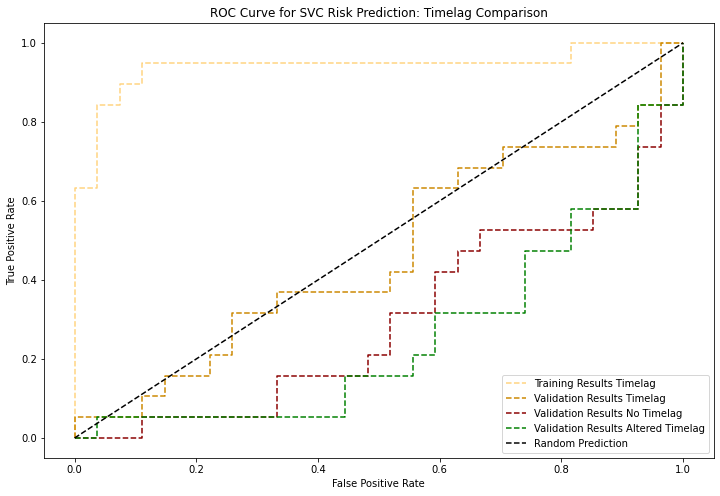

AUC scores

Train data w/ Timelag: 0.9395711500974658
Validation data w/ Timelag: 0.4678362573099415

Validation data no Timelag: 0.29824561403508776

Validation data Timelag altered: 0.25536062378167645


In [34]:
# train including timelag
# t_fpr, t_tpr, _ = roc_curve(train_labels, predictions)
t_fpr_2, t_tpr_2, _ = roc_curve(train_labels, pred_prob1[:,1])

# validate including timelag
# tv_fpr, tv_tpr, _ = roc_curve(train_labels, val_results.pred)
tv_fpr_2, tv_tpr_2, _ = roc_curve(train_labels, val_results.predprob1)

# train no timelag
# x_fpr, x_tpr, _ = roc_curve(train_labels, predictions_2)
# x_fpr_2, x_tpr_2, _ = roc_curve(train_labels, predictions_prob_2[:,1])

# validate no timelag
# xv_fpr, xv_tpr, _ = roc_curve(train_labels, val_results_notimelag.pred)
xv_fpr_2, xv_tpr_2, _ = roc_curve(train_labels, val_results2.predprob1)

# validate altered timelag
# lv_fpr, lv_tpr, _ = roc_curve(train_labels_s, val_results_timelag300.pred)
# lv_fpr_2, lv_tpr_2, _ = roc_curve(train_labels_s, val_results_timelag300.predprob1)
lv_fpr_2, lv_tpr_2, _ = roc_curve(train_labels, val_results_m.predprob1)





random_pred = [0 for _ in range(len(train_labels))]
r_fpr, r_tpr, _ = roc_curve(train_labels, random_pred)



plt.figure(figsize=(12,8))
# plt.plot(t_fpr, t_tpr, label='With Timelag - Hard Prediction', color='orange')
plt.plot(t_fpr_2, t_tpr_2, linestyle='--', label='Training Results Timelag', color='#ffd480')
plt.plot(tv_fpr_2, tv_tpr_2, linestyle='--', label='Validation Results Timelag', color='#cc8800')


# plt.plot(x_fpr, x_tpr, label='No Timelag - Hard Prediction', color='blue')
# plt.plot(x_fpr_2, x_tpr_2, linestyle='--', label='No Timelag(Train) - Probability Prediction', color='lightblue')
plt.plot(xv_fpr_2, xv_tpr_2, linestyle='--', label='Validation Results No Timelag', color='darkred')

# plt.plot(x_fpr_2, x_tpr_2, linestyle='--', label='No Timelag(Train) - Probability Prediction', color='lightblue')
plt.plot(lv_fpr_2, lv_tpr_2, linestyle='--', label='Validation Results Altered Timelag', color='green')



plt.plot(r_fpr, r_tpr, linestyle='--', label='Random Prediction', color='black')


plt.title('ROC Curve for SVC Risk Prediction: Timelag Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


print('AUC scores\n')
print('Train data w/ Timelag:',auc(t_fpr_2, t_tpr_2))
print('Validation data w/ Timelag:',auc(tv_fpr_2, tv_tpr_2))
print()
# print('Train data no Timelag:',auc(x_fpr_2, x_tpr_2))
print('Validation data no Timelag:',auc(xv_fpr_2, xv_tpr_2))
print()
print('Validation data Timelag altered:',auc(lv_fpr_2, lv_tpr_2))

# print('No Timelag:',auc(x_fpr, x_tpr))



**REGRESSION ON TIMELAG**

In [ ]:
corr = df.corr()
corr['Timelag'].sort_values(ascending=False)

In [ ]:
reg_train_data = df.drop(['Timelag'], axis=1)
reg_labels = df['Timelag'].copy()
print(reg_train_data.shape)
print(reg_labels.shape)

In [ ]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

onehot_features = ['Race', 'Tumor_Loc'] # race -> 3 dim, Loc -> 5 dim
smoke_cats = [np.array(['Never', 'Former', 'Former(30+)', 'Current'])]
num_features = list(reg_train_data.drop(['Race', 'Tumor_Loc', 'Smoke'], axis=1).columns)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat_ord", OrdinalEncoder(categories=smoke_cats), ['Smoke']),
        ("cat_onehot", OneHotEncoder(), onehot_features), 
    ])
reg_data_prep = full_pipeline.fit_transform(reg_train_data)
reg_data_prep.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
reg = RandomForestRegressor()
reg.fit(reg_data_prep[:30], reg_labels[:30])
reg_pred = reg.predict(reg_data_prep)

train_rmse = np.sqrt(mean_squared_error(reg_labels[:30], reg_pred[:30]))
val_rmse = np.sqrt(mean_squared_error(reg_labels[30:], reg_pred[30:]))
overall_rmse = np.sqrt(mean_squared_error(reg_labels, reg_pred))

print('Train RMSE:', str(train_rmse)[:6], '~=', str(train_rmse/365)[:3], 'years')
print('Val RMSE:', str(val_rmse)[:6], '~=', str(val_rmse/365)[:3], 'years')
print('Overall RMSE:', str(overall_rmse)[:6], '~=', str(overall_rmse/365)[:3], 'years')

In [ ]:
for i in range(len(df)):
    if i == 30:
        print('\nValidation****')
    row = df.iloc[i]
    actual_years =str(row.Timelag/365)[:3]
    pred_years= str(reg_pred[i]/365)[:3]
    
    percent_error=str((np.abs(reg_pred[i] - row.Timelag)/row.Timelag)*100)[:4] +'%'
    print('Actual:', actual_years, 'Pred:', pred_years, '-- PERCENT ERROR:', percent_error)